## IRFs from dl2 files

This file describes the fastest possible way to calculate irfs from a dl2 ctapipe file. For now, this only includes the "signal" irfs Aeff, Edsip and PSF.

In [1]:
import numpy as np
from dl2_tools.handler import sim_datasets,observation_handler,binning
from dl2_tools.maker import cut_optimizer,irf_maker
from gammapy.maps import MapAxis
import astropy.units as u
import matplotlib.pyplot as plt
import pkg_resources
import os

/d1/hin/gschwefer/miniconda/envs/dl2_tools/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Get the directory where the data that comes with the package is stored

In [2]:
dl2_tools_dir = pkg_resources.resource_filename("dl2_tools","")
data_dir = os.path.join(dl2_tools_dir, 'data')

Individual datafiles are stored as DataSets. in this case, because we have gammas from a point-like simulation, it is a PointSOurceSignalSet. To instantiate this, you need to specify the prefix of the table columns that contain the reconstructed energy, geometry and the gamma/hadron separation score

In [15]:
signal=sim_datasets.PointSourceSignalSet.from_path(os.path.join(data_dir,"dl2_files/1-2run_gamma_20deg_0deg___cta-prod6-paranal-2147m-Paranal-nshow-100000-0-LSTs-14-MSTs-0-SSTs-NSCAT_5_CSCAT_1000-nsb-0.216-GHz_off0.0..FCExt--HillasReco--RF_red_100_est_dpth_20_01_lk_cut_int_wgt--IP_NC_dummy----RFCl_100_est_dpth_20_int_wgt.dl2.h5"),reco_energy_name="RF_red_100_est_dpth_20_01_lk_cut_int_wgt",geometry_name="HillasReconstructor",gh_score_name="RFCl_100_est_dpth_20_int_wgt")

Multiple signal and (in general, but not here) background files are together contained in an ObservationHandler. In this case it is a PointSourceObservationHandler

In [4]:
observation=observation_handler.PointSourceObservationHandler(signal=[signal])

From an observation, the IRFs are created by an IRFMaker object. This is instantiated here.

In [5]:
irfmaker=irf_maker.IRFMaker()


In the next step, the binning is created. This is not strictly necessary because the IRFMaker can autogenerate a binning, but is put here nonetheless. Note that an observation must always be passed to an IRFBinning object. That is because the axis in fov offset is generated automatically from this obsevration. The axes are provided as gammapy MapAxis objects

In [9]:
energy_true_axis=MapAxis.from_energy_bounds(10*u.GeV,100*u.TeV,7,per_decade=True)
migration_axis=MapAxis(np.geomspace(0.001,10,300),interp="log",node_type="edges")
psf_offset=MapAxis.from_bounds(0.0*u.deg,2.0*u.deg,200)

bins=binning.IRFBinning(observation)
bins.energy_true=energy_true_axis
bins.migration=migration_axis
bins.psf_offset=psf_offset


Now we call the IRFMaker on our observation. This returns an IRFHandler object that contains all the IRFs in gammapy format.

In [10]:
irfs=irfmaker(observation,binning=bins)

We can now plot these using the functions provided by gammapy. First, the 68% conatinment radius. The jiggly curve is due to the low statistics of the example data set

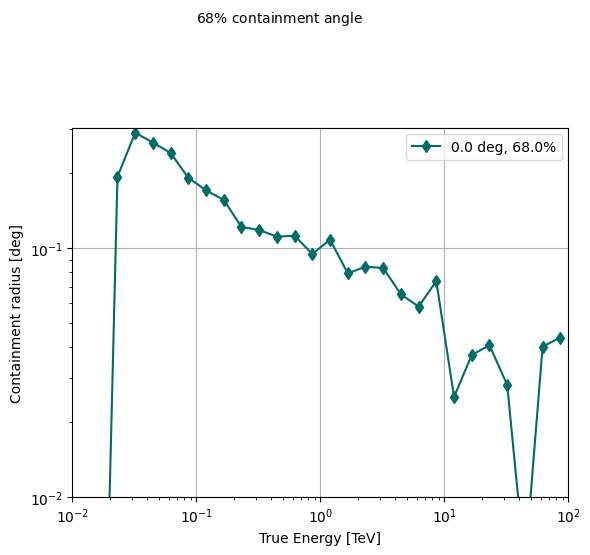

In [11]:
fig,ax=plt.subplots()
irfs.psf.plot_containment_radius_vs_energy(ax,offset=[0.0]*u.deg,fraction=[0.68],color="#006C66",marker="d")
ax.text(x=0.1*u.TeV,y=0.81*u.deg,s="$68\%$ containment angle")
ax.set_xlim(left=0.01*u.TeV)
ax.set_ylim(bottom=1e-2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid()
plt.show()

Next, we can also look at the energy dispersion

In [12]:
edisp_kernel=irfs.edisp.to_edisp_kernel(offset=0.0*u.deg,energy_true=energy_true_axis.edges,energy=energy_true_axis.edges)
res=edisp_kernel.get_resolution(energy_true_axis.center)

/d1/hin/gschwefer/miniconda/envs/dl2_tools/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


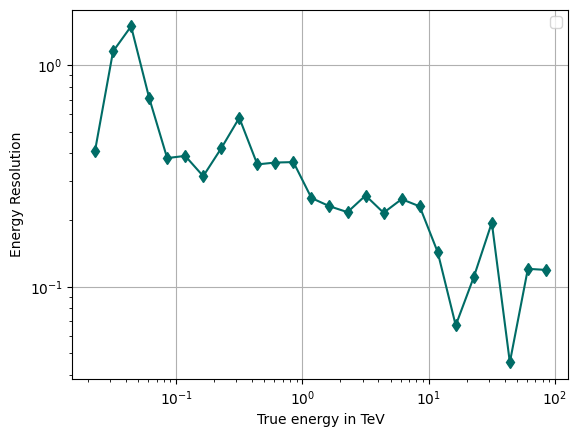

In [14]:
fig,ax=plt.subplots()

ax.plot(energy_true_axis.center,res,color="#006c66",linestyle="solid",marker="d")


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("True energy in TeV")
ax.set_ylabel("Energy Resolution")

ax.legend()
ax.grid(visible=True)